## main liberaries

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


## load the data

In [2]:
# Path to the dataset
data_path = 'D:/3-Deep Learning/DataSets for Deep Learning/Cats and Dogs'

# Function to load images and labels
def load_data(dataset_path):
    images = []
    labels = []
    for label, category in enumerate(['dogs', 'cats']):
        category_path = os.path.join(dataset_path, 'training_set', category)
        for img_file in os.listdir(category_path):
            img_path = os.path.join(category_path, img_file)
            image = cv2.imread(img_path)
            image = cv2.resize(image, (150, 150))  # Resize images to a consistent size
            images.append(image)
            labels.append(label)  # Assign 0 for dogs and 1 for cats

    return np.array(images), np.array(labels)



In [3]:
# Load the training dataset
train_images, train_labels = load_data(data_path)

# Load the test dataset
test_images, test_labels = load_data(data_path.replace('training_set', 'test_set'))


## split the data

In [4]:
# Split the training data into train and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, 
                                                                      test_size=0.2, random_state=42)

## Normalize pixel values to a range of 0 to 1

In [5]:
# Normalize pixel values to a range of 0 to 1
train_images = train_images.astype('float32') / 255.0
val_images = val_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

## show the shapes

In [6]:
print("Train images shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)
print("Validation images shape:", val_images.shape)
print("Validation labels shape:", val_labels.shape)
print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)

Train images shape: (6404, 150, 150, 3)
Train labels shape: (6404,)
Validation images shape: (1601, 150, 150, 3)
Validation labels shape: (1601,)
Test images shape: (8005, 150, 150, 3)
Test labels shape: (8005,)


## Exploratory data analysis (EDA)

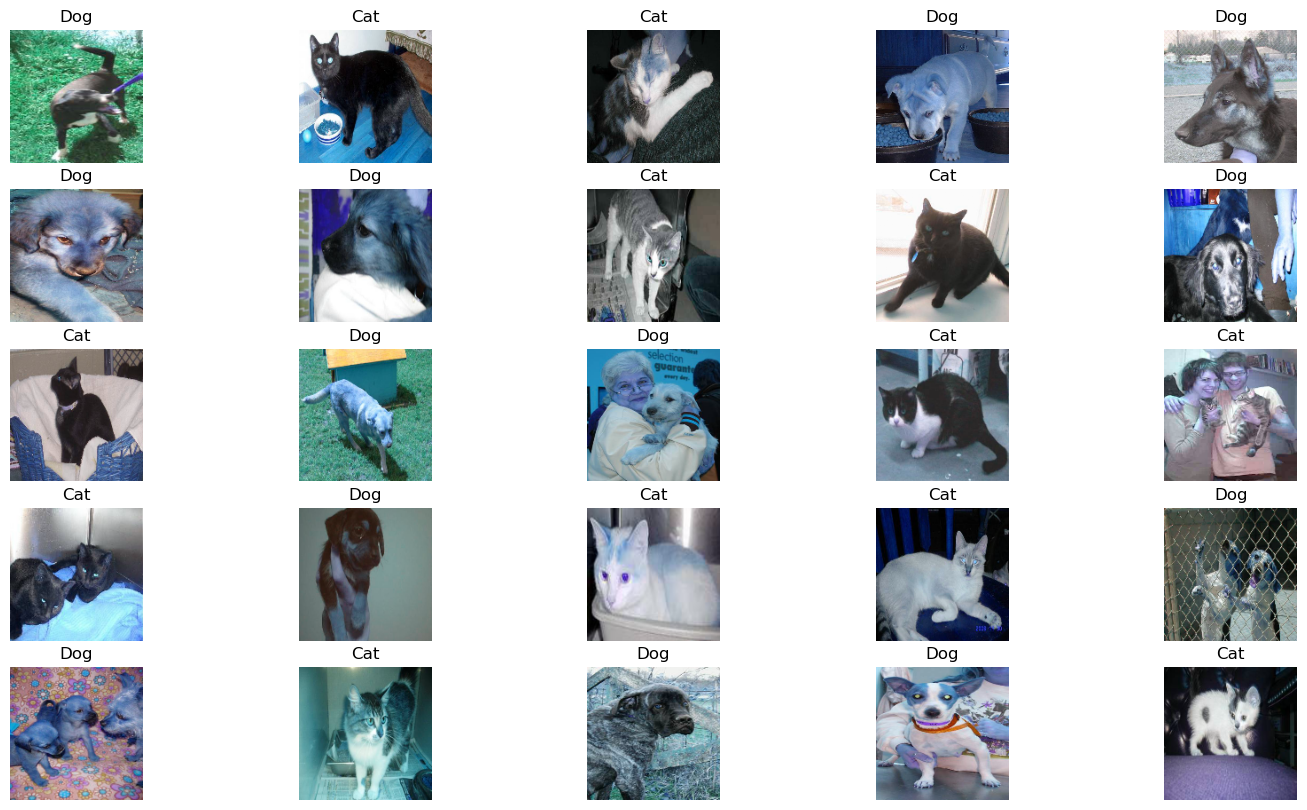

In [14]:
# Display some sample images from the training set
plt.figure(figsize=(18, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(train_images[i])
    if train_labels[i] == 0:
        plt.title("Dog")
    else:
        plt.title("Cat")
    plt.axis('off')
plt.show()


### ` Class Distribution`

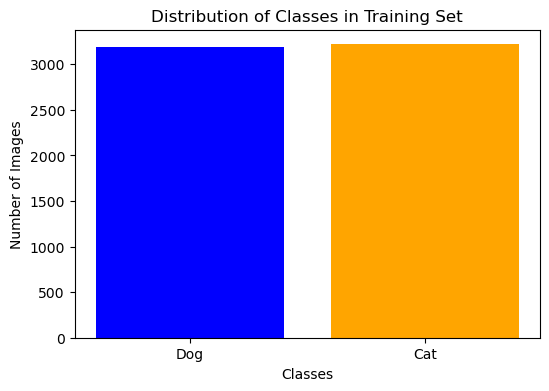

In [8]:
# Count the number of images for each class in the training set
unique, counts = np.unique(train_labels, return_counts=True)
class_count = dict(zip(unique, counts))

# Plotting the distribution of classes
plt.figure(figsize=(6, 4))
plt.bar(class_count.keys(), class_count.values(), color=['blue', 'orange'])
plt.xticks(list(class_count.keys()), ['Dog', 'Cat'])
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Distribution of Classes in Training Set')
plt.show()


### ` Image Size Distribution`

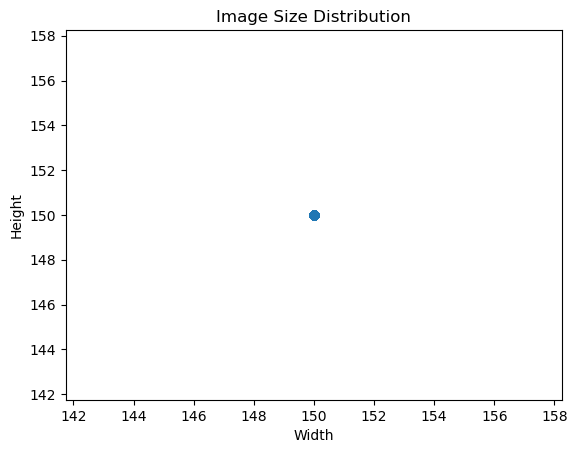

In [9]:
# Image Size Distribution
sizes = [img.shape[:2] for img in train_images]
sizes = np.array(sizes)

plt.scatter(sizes[:, 0], sizes[:, 1])
plt.xlabel('Width')
plt.ylabel('Height')
plt.title('Image Size Distribution')
plt.show()


### `Pixel Intensity Distribution`

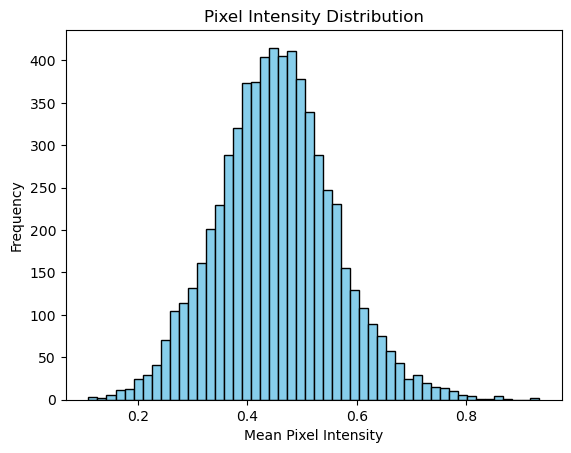

In [10]:
# Pixel Intensity Distribution
mean_intensities = [np.mean(img) for img in train_images]

plt.hist(mean_intensities, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Mean Pixel Intensity')
plt.ylabel('Frequency')
plt.title('Pixel Intensity Distribution')
plt.show()


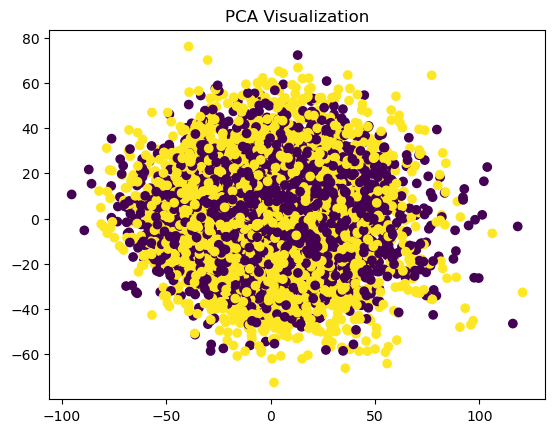

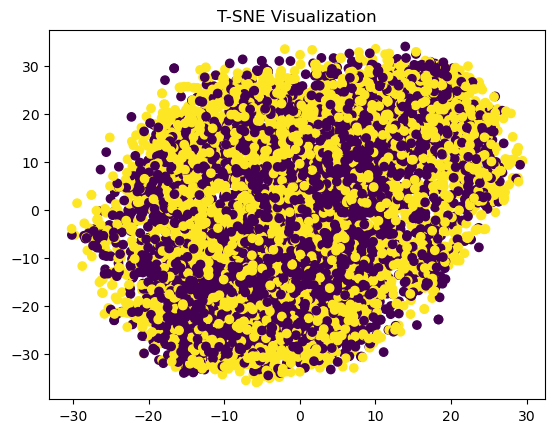

In [11]:
# Reshape images for feature extraction
reshaped_images = train_images.reshape(train_images.shape[0], -1)

# PCA for dimensionality reduction
pca = PCA(n_components=2)
pca_result = pca.fit_transform(reshaped_images)
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=train_labels, cmap='viridis')
plt.title('PCA Visualization')
plt.show()

# T-SNE for visualizing high-dimensional data
tsne = TSNE(n_components=2)
tsne_result = tsne.fit_transform(reshaped_images)
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=train_labels, cmap='viridis')
plt.title('T-SNE Visualization')
plt.show()


## the model

In [12]:

# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks 
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(train_images, train_labels, epochs=20, batch_size=32,
                    validation_data=(val_images, val_labels),
                    callbacks=[checkpoint, early_stopping])


Epoch 1/20
201/201 [==============================] - ETA: 0s - loss: 0.6563 - accuracy: 0.5959
Epoch 1: val_accuracy improved from -inf to 0.66271, saving model to best_model.h5


F:\anaconda\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


201/201 [==============================] - 189s 928ms/step - loss: 0.6563 - accuracy: 0.5959 - val_loss: 0.6035 - val_accuracy: 0.6627
Epoch 2/20
201/201 [==============================] - ETA: 0s - loss: 0.5760 - accuracy: 0.6968
Epoch 2: val_accuracy improved from 0.66271 to 0.69956, saving model to best_model.h5
201/201 [==============================] - 183s 910ms/step - loss: 0.5760 - accuracy: 0.6968 - val_loss: 0.5598 - val_accuracy: 0.6996
Epoch 3/20
201/201 [==============================] - ETA: 0s - loss: 0.5288 - accuracy: 0.7414
Epoch 3: val_accuracy improved from 0.69956 to 0.72580, saving model to best_model.h5
201/201 [==============================] - 191s 949ms/step - loss: 0.5288 - accuracy: 0.7414 - val_loss: 0.5185 - val_accuracy: 0.7258
Epoch 4/20
201/201 [==============================] - ETA: 0s - loss: 0.4930 - accuracy: 0.7647
Epoch 4: val_accuracy improved from 0.72580 to 0.75141, saving model to best_model.h5
201/201 [==============================] - 191s 9

### `Plotting training history`

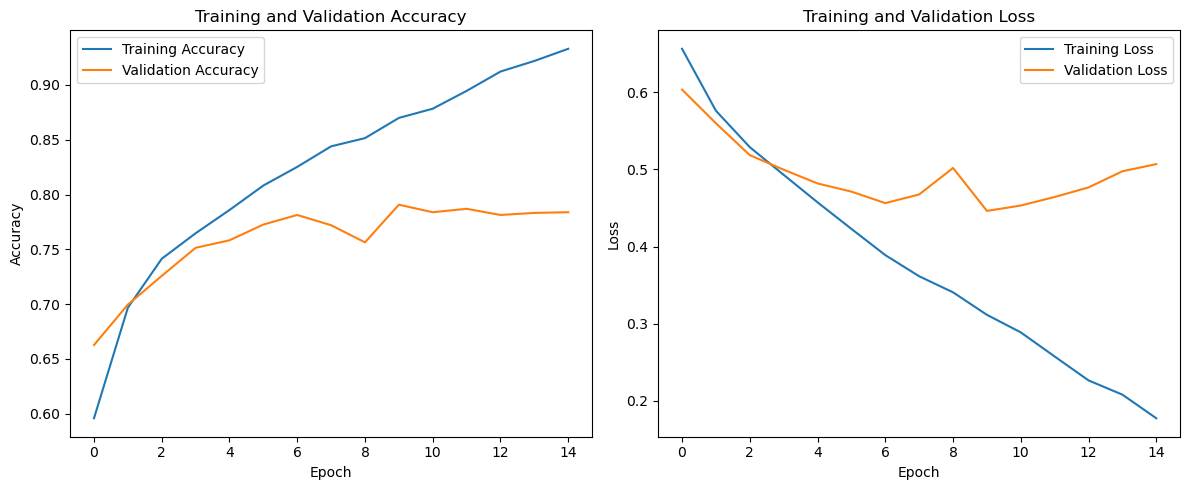

In [13]:

# Plotting training history
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

### `evaluation and prediction`

In [15]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Test Loss: {loss:.4f}")

# Make predictions on the test set
predictions = model.predict(test_images)
predicted_labels = (predictions > 0.5).astype('int32').reshape(-1)  # Convert probabilities to binary predictions (0 or 1)



251/251 [==============================] - 39s 153ms/step - loss: 0.2926 - accuracy: 0.8816
Test Accuracy: 88.16%
Test Loss: 0.2926
251/251 [==============================] - 38s 152ms/step


### `predictions vs actual`

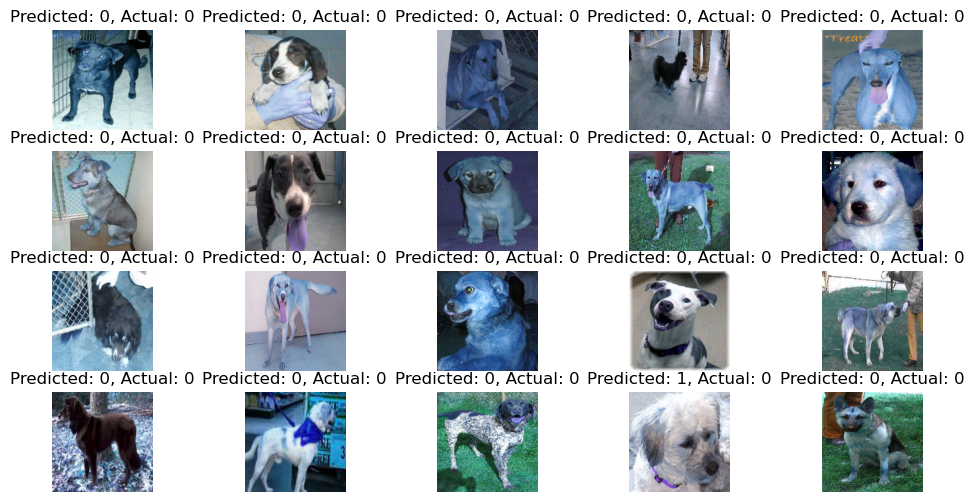

In [19]:
# Visualize predictions vs actual labels
plt.figure(figsize=(12, 6))
for i in range(20):  # Display a few predictions
    plt.subplot(4, 5, i + 1)
    plt.imshow(test_images[i])
    plt.title(f"Predicted: {predicted_labels[i]}, Actual: {test_labels[i]}")
    plt.axis('off')
plt.show()